In [6]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1"

In [1]:
import math
import pprint
import sys
from typing import List

import clrs
from clrs.examples import run as run_lib

import jax
import jaxlib
from matplotlib import pyplot as plt
import numpy as np

2025-01-11 14:08:44.189137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736584724.203637 2917380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736584724.207952 2917380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
clrs.specs.CLRS_30_ALGS

['articulation_points',
 'activity_selector',
 'bellman_ford',
 'bfs',
 'binary_search',
 'bridges',
 'bubble_sort',
 'dag_shortest_paths',
 'dfs',
 'dijkstra',
 'find_maximum_subarray_kadane',
 'floyd_warshall',
 'graham_scan',
 'heapsort',
 'insertion_sort',
 'jarvis_march',
 'kmp_matcher',
 'lcs_length',
 'matrix_chain_order',
 'minimum',
 'mst_kruskal',
 'mst_prim',
 'naive_string_matcher',
 'optimal_bst',
 'quickselect',
 'quicksort',
 'segments_intersect',
 'strongly_connected_components',
 'strongly_connected_components_v2',
 'task_scheduling',
 'topological_sort']

In [5]:
# initialise a JAX random number generator
rng = np.random.RandomState(179)
rng_key = jax.random.PRNGKey(rng.randint(2**32))

In [6]:
def print_data_batch(example_data_batch):
  print('Outputs:')
  for x in example_data_batch.outputs:
    print(x)
  print('\nFeatures:')
  print('Inputs:')
  for x in example_data_batch.features.inputs:
    print(x)
  print('Hints:')
  for x in example_data_batch.features.hints:
    print(x)
  print('Lengths:')
  print(example_data_batch.features.lengths)
  print('-----\n')

In [7]:
def draw_plots(
    train_losses: List[List[float]],
    val_accs: List[List[float]],
    test_accs: List[float],
    algorithms: List[str],
    window_size: int = 10,
):
  """Draw plots for train losses and validation/test accuracies.

  Args:
    train_losses: list of training losses for each algorithm.
    val_accs: list of validation accuracies for each algorithm.
    test_accs: list of test accuracies for each algorithm.
    algorithms: list of algorithms to plot.
    window_size: size of moving average window for train losses.
  """
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
  num_algos = len(algorithms)

  _, axes = plt.subplots(2, num_algos, figsize=(5 * num_algos, 10), squeeze=False)


  for algo_idx, (algorithm, train_loss, val_acc, test_acc) in enumerate(
      zip(algorithms, train_losses, val_accs, test_accs)
  ):
    # Calculate moving average for train_loss
    smoothed_losses = [
        sum(train_loss[i : i + window_size]) / window_size
        for i in range(len(train_loss) - window_size + 1)
    ]
    axes[0, algo_idx].plot(
        smoothed_losses,
        label=f'Train loss ({algorithm})',
        color=colors[algo_idx % len(colors)],
    )
    axes[0, algo_idx].set_ylabel('Loss')
    axes[0, algo_idx].set_title(f'{algorithm}')

    axes[1, algo_idx].plot(
        [s * 50 for s in range(len(val_acc))],
        val_acc,
        label=f'Validation accuracy ({algorithm})',
        color=colors[algo_idx % len(colors)],
    )
    axes[1, algo_idx].axhline(
        y=test_acc,
        linestyle='--',
        label=f'Test accuracy ({algorithm})',
        color=colors[algo_idx % len(colors)],
    )
    axes[1, algo_idx].set_ylabel('Accuracy')
    axes[1, algo_idx].set_ylim(0, 1)

    for row in range(2):
      axes[row, algo_idx].set_xlabel('Step')
      axes[row, algo_idx].legend()
      axes[row, algo_idx].grid()

  plt.tight_layout()
  plt.show()

In [8]:
run_lib.FLAGS(['colab_run'])

['colab_run']

In [9]:
run_lib.create_samplers

<function clrs.examples.run.create_samplers(rng, train_lengths: List[int], *, algorithms: Optional[List[str]] = None, val_lengths: Optional[List[int]] = None, test_lengths: Optional[List[int]] = None, train_batch_size: int = 32, val_batch_size: int = 32, test_batch_size: int = 32)>

In [10]:
# by default in create_samplers() number of samples is 1000, 32, 32 for train, val, test
train_lengths = [8, 16]
val_lengths = [16]
test_lengths = [32]
# You can any of 30 available algorithms
algorithms = ['dfs', 'strongly_connected_components_v2']

(
    train_samplers,
    val_samplers,
    val_sample_counts,
    test_samplers,
    test_sample_counts,
    spec_list,
) = run_lib.create_samplers(
    rng=rng,
    train_lengths=train_lengths,
    val_lengths=val_lengths,
    test_lengths=test_lengths,
    algorithms=algorithms,	
)

I0000 00:00:1736584727.684168 2917380 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:4b:00.0, compute capability: 8.9


In [11]:
pprint.pprint(spec_list)

[{'A': ('input', 'edge', 'scalar'),
  'adj': ('input', 'edge', 'mask'),
  'color': ('hint', 'node', 'categorical'),
  'd': ('hint', 'node', 'scalar'),
  'f': ('hint', 'node', 'scalar'),
  'pi': ('output', 'node', 'pointer'),
  'pi_h': ('hint', 'node', 'pointer'),
  'pos': ('input', 'node', 'scalar'),
  's': ('hint', 'node', 'mask_one'),
  's_last': ('hint', 'node', 'mask_one'),
  's_prev': ('hint', 'node', 'pointer'),
  's_prev_reversal': ('hint', 'node', 'pointer'),
  'time': ('hint', 'graph', 'scalar'),
  'u': ('hint', 'node', 'mask_one'),
  'v': ('hint', 'node', 'mask_one')},
 {'A': ('input', 'edge', 'scalar'),
  'A_t': ('hint', 'edge', 'mask'),
  'adj': ('input', 'edge', 'mask'),
  'color': ('hint', 'node', 'categorical'),
  'd': ('hint', 'node', 'scalar'),
  'f': ('hint', 'node', 'scalar'),
  'phase': ('hint', 'graph', 'mask'),
  'pos': ('input', 'node', 'scalar'),
  's': ('hint', 'node', 'mask_one'),
  's_last': ('hint', 'node', 'mask_one'),
  's_prev': ('hint', 'node', 'pointer'

In [12]:
new_example_data_batch = [next(t) for t in train_samplers]
for x in new_example_data_batch:
  print_data_batch(x)

Outputs:
DataPoint(name="pi",	location=node,	type=pointer,	data=Array(32, 8))

Features:
Inputs:
DataPoint(name="pos",	location=node,	type=scalar,	data=Array(32, 8))
DataPoint(name="A",	location=edge,	type=scalar,	data=Array(32, 8, 8))
DataPoint(name="adj",	location=edge,	type=mask,	data=Array(32, 8, 8))
Hints:
DataPoint(name="pi_h",	location=node,	type=pointer,	data=Array(24, 32, 8))
DataPoint(name="color",	location=node,	type=categorical,	data=Array(24, 32, 8, 3))
DataPoint(name="d",	location=node,	type=scalar,	data=Array(24, 32, 8))
DataPoint(name="f",	location=node,	type=scalar,	data=Array(24, 32, 8))
DataPoint(name="s_prev",	location=node,	type=pointer,	data=Array(24, 32, 8))
DataPoint(name="s_prev_reversal",	location=node,	type=pointer,	data=Array(24, 32, 8))
DataPoint(name="s",	location=node,	type=mask_one,	data=Array(24, 32, 8))
DataPoint(name="u",	location=node,	type=mask_one,	data=Array(24, 32, 8))
DataPoint(name="v",	location=node,	type=mask_one,	data=Array(24, 32, 8))
DataP

In [13]:
# processor_factory = get_processor_factory(
#     nb_triplet_fts=4, use_ln=True
# )

processor_factory = clrs.get_processor_factory(
    'triplet_gmpnn', nb_triplet_fts=4, use_ln=False
)

model_params = dict(
    processor_factory=processor_factory,  # Our factory function
    hidden_dim=64,  # The latent dimension (k, l above)
    encode_hints=True,  # Should we encode the trace?
    decode_hints=True,  # Should we decode/learn on the trace?
    learning_rate=0.001,  # Base learning rate for Adam
    grad_clip_max_norm=1.0,  # Maximum norm of gradient before clip
    checkpoint_path='tmp/clrs',
    debug=True,  # We will talk about this parameter in part 2
    use_lstm=True
)

train_model = clrs.models.BaselineModel(
    spec=spec_list,  # Use the spec to tell us how to encode/decode
    dummy_trajectory=new_example_data_batch,  # JAX requires example trace to initialise
    **model_params,  # Our model parameter dictionary
)

# Calling model.init(inputs, seed) initialises the parameters of the model.
train_model.init([x.features for x in new_example_data_batch], 179)

In [14]:
train_model.save_model('init.pkl')  # We will need it in part 2

In [15]:
def train_loop(rng_key, train_model, train_samplers, val_samplers, test_samplers, num_steps=500):
  best_val_acc = -1.0

  # Collect all observed losses, and accuracies here for plotting purposes
  train_losses = [[] for _ in train_samplers]
  val_accs = [[] for _ in val_samplers]
  test_acc = [-1.0 for _ in test_samplers]

  for step in range(num_steps):
    # Training step.
    for algo_idx, sampler in enumerate(train_samplers):
      train_batch = next(sampler)
      rng_key, rng_subkey = jax.random.split(rng_key)
      train_losses[algo_idx].append(
          train_model.feedback(rng_subkey, train_batch, algo_idx)
      )

    # Periodically evaluate model
    if step % 50 == 0:
      print(f'step = {step}')
      for algo_idx, val_sampler in enumerate(val_samplers):
        rng_key, rng_subkey = jax.random.split(rng_key)
        val_batch = next(val_sampler)
        predictions, hint_predictions, _ = train_model.predict(
            rng_key, val_batch.features, algo_idx
        )
        val_accs[algo_idx].append(
            clrs.evaluate(val_batch.outputs, predictions)['score']
        )
        print(
            f'{algorithms[algo_idx]} \t| val_acc ='
            f' {val_accs[algo_idx][-1]:.3f} \t| loss ='
            f' {train_losses[algo_idx][-1]:.3f}'
        )

      current_accuracy = sum([val_accs_row[-1] for val_accs_row in val_accs])
      if current_accuracy > best_val_acc:  # new best model found
        for algo_idx, test_sampler in enumerate(test_samplers):
          rng_key, rng_subkey = jax.random.split(rng_key)
          test_batch = next(test_sampler)
          predictions, hint_predictions, _ = train_model.predict(
              rng_subkey, test_batch.features, algo_idx
          )
          test_acc[algo_idx] = clrs.evaluate(test_batch.outputs, predictions)[
              'score'
          ]
        best_val_acc = current_accuracy
        train_model.save_model('best.pkl')

  return train_losses, val_accs, test_acc

In [16]:
train_losses, val_accs, test_acc = train_loop(
    rng_key, train_model, train_samplers, val_samplers, test_samplers, num_steps=1500
)

2025-01-11 14:10:27.028202: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB (rounded to 2232665088)requested by op 
2025-01-11 14:10:27.028579: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] **__________________________________________________________________________________________________
E0111 14:10:27.028961 2917380 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2232664888 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2232664888 bytes.

In [46]:
print(test_acc)

[0.923828125, 0.7685546875]


In [47]:
train_model.restore_model('best.pkl', only_load_processor=False)


In [50]:
train_lengths = [5]
val_lengths = [5]
test_lengths = [32]
# You can any of 30 available algorithms
algorithms = ['dfs', 'strongly_connected_components_v2']

(
    train_samplers,
    val_samplers,
    val_sample_counts,
    test_samplers,
    test_sample_counts,
    spec_list,
) = run_lib.create_samplers(
    rng=rng,
    train_lengths=train_lengths,
    val_lengths=val_lengths,
    test_lengths=test_lengths,
    algorithms=algorithms,
)

In [31]:
test_samplers

[<generator object make_multi_sampler.<locals>.cycle_samplers at 0x7fe3145ef840>,
 <generator object make_multi_sampler.<locals>.cycle_samplers at 0x7fe4ec385700>]

In [49]:
def testing(train_model, n, algo_id, rng_key):
    tot = 0
    for i in range(n):
        train_lengths = [5]
        val_lengths = [5]
        test_lengths = [32]
        # You can any of 30 available algorithms
        algorithms_tmp = [algorithms[algo_id]]

        (
            train_samplers,
            val_samplers,
            val_sample_counts,
            test_samplers,
            test_sample_counts,
            spec_list,
        ) = run_lib.create_samplers(
            rng=rng,
            train_lengths=train_lengths,
            val_lengths=val_lengths,
            test_lengths=test_lengths,
            algorithms=algorithms_tmp,
        )

        test_batch = next(test_samplers[0])
        predictions, hint_predictions, hidden_layers = train_model.predict(rng_key, test_batch.features, algo_id, return_hints=True)

        tot += clrs.evaluate(test_batch.outputs, predictions)['score']
        print(clrs.evaluate(test_batch.outputs, predictions)['score'])
    print(tot/n)

testing(train_model, 10, 1, rng_key)

0.771484375


0.7626953125


0.7353515625


0.73828125


0.7841796875


0.7236328125


0.8369140625


0.791015625


0.7607421875


0.7734375
0.7677734375


In [52]:
h = None
hd = None
test_batch = 0
test_batch_d = 0

def describe_model(train_model, test_samplers, algorithms, rng_key):
    for algo_idx, test_sampler in enumerate(test_samplers):
        rng_key, rng_subkey = jax.random.split(rng_key)
        global test_batch, test_batch
        test_batch = next(test_sampler)
        if algo_idx == 0:
            test_batch_d = test_batch
        predictions, hint_predictions, hidden_layers = train_model.predict(rng_subkey, test_batch.features, algo_idx, return_hints=True)
        print(f"Predictions for {algorithms[algo_idx]}:")
        print(predictions)
        print(f"Hint predictions for {algorithms[algo_idx]}:")
        # print(hint_predictions)
        global h, hd
        h = hint_predictions
        if algo_idx == 0:
            hd = hint_predictions
        # return
        print("Timesteps:", hidden_layers.shape[0])
        print("Nodes:", hidden_layers.shape[2])
        print("Features:", hidden_layers.shape[3])
        print(hidden_layers.shape)

        print("Accuracy:", clrs.evaluate(test_batch.outputs, predictions)['score'])

describe_model(train_model, test_samplers, algorithms, rng_key)

Predictions for dfs:
{'pi': DataPoint(name="pi",	location=node,	type=pointer,	data=Array(32, 32))}
Hint predictions for dfs:
Timesteps: 95
Nodes: 32
Features: 64
(95, 32, 32, 64)
Accuracy: 0.904296875
Predictions for strongly_connected_components_v2:
{'scc_id': DataPoint(name="scc_id",	location=node,	type=pointer,	data=Array(32, 32))}
Hint predictions for strongly_connected_components_v2:
Timesteps: 166
Nodes: 32
Features: 64
(166, 32, 32, 64)
Accuracy: 0.7568359375


In [53]:
test_batch.features.hints

(DataPoint(name="scc_id_h",	location=node,	type=pointer,	data=Array(167, 32, 32)),
 DataPoint(name="A_t",	location=edge,	type=mask,	data=Array(167, 32, 32, 32)),
 DataPoint(name="color",	location=node,	type=categorical,	data=Array(167, 32, 32, 3)),
 DataPoint(name="d",	location=node,	type=scalar,	data=Array(167, 32, 32)),
 DataPoint(name="f",	location=node,	type=scalar,	data=Array(167, 32, 32)),
 DataPoint(name="s_prev",	location=node,	type=pointer,	data=Array(167, 32, 32)),
 DataPoint(name="s_prev_reversal",	location=node,	type=pointer,	data=Array(167, 32, 32)),
 DataPoint(name="s",	location=node,	type=mask_one,	data=Array(167, 32, 32)),
 DataPoint(name="u",	location=node,	type=mask_one,	data=Array(167, 32, 32)),
 DataPoint(name="v",	location=node,	type=mask_one,	data=Array(167, 32, 32)),
 DataPoint(name="s_last",	location=node,	type=mask_one,	data=Array(167, 32, 32)),
 DataPoint(name="time",	location=graph,	type=scalar,	data=Array(167, 32)),
 DataPoint(name="phase",	location=graph,	t

In [54]:
def plot_two_lines(data1, data2, x_label, y_label, marked_point_data1):
  """Plots two lines on the same graph with specified labels and a marked point.

  Args:
    data1: A list of tuples, where each tuple represents a point (x, y) for the first line.
    data2: A list of tuples, where each tuple represents a point (x, y) for the second line.
    x_label: Label for the x-axis.
    y_label: Label for the y-axis.
    marked_point_data1: A tuple (x,y) representing the point to mark on the first line with a red dot.
  """
  x1, y1 = zip(*data1)
  x2, y2 = zip(*data2)

  plt.plot(x1, y1, label='Line 1')
  plt.plot(x2, y2, label='Line 2')

  # Mark the specified point on the first line with a red dot
  marked_x, marked_y = marked_point_data1
  plt.plot(marked_x, marked_y, 'ro', label='Marked Point')

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title('Two Lines Plot')
  plt.legend()
  plt.grid(True)
  plt.show()

# prompt: plot multiple line graphs from list of list of tuples

import matplotlib.pyplot as plt

def plot_multiple_lines(data, x_label, y_label):
    """Plots multiple lines on the same graph.

    Args:
      data: A list of lists of tuples, where each inner list represents a line
            and each tuple represents a point (x, y) on that line.
      x_label: Label for the x-axis.
      y_label: Label for the y-axis.
      legends: A list of strings representing the legend for each line.
    """
    for i, line_data in enumerate(data):
        x, y = zip(*line_data)
        plt.plot(x, y)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Multiple Lines Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

In [57]:
data = []
for j in range(1):
    L = [(0, 0) for i in range(len(h))]
    L2 = [(0, 0) for i in range(len(h))]
    for i in range(len(h)):
        # if h[i]['phase'][j] > 0:
        #     print('pred', i)
            # print(h[i]['color'][j])
        L[i] = (i, h[i]['phase'][j])
        L2[i] = (i, test_batch.features.hints[-1].data[i][j])
        # if test_batch.features.hints[-1].data[i+2][j] > 0:
        #     print(i)
        #     print(h[i]['color'][j])
        # if test_batch.features.hints[-1].data[i][j] > 0 and h[i]['phase'][j] > 0:
        #     break
    data.append(L)
    data.append(L2)


/tmp/ipykernel_2517774/2047352291.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


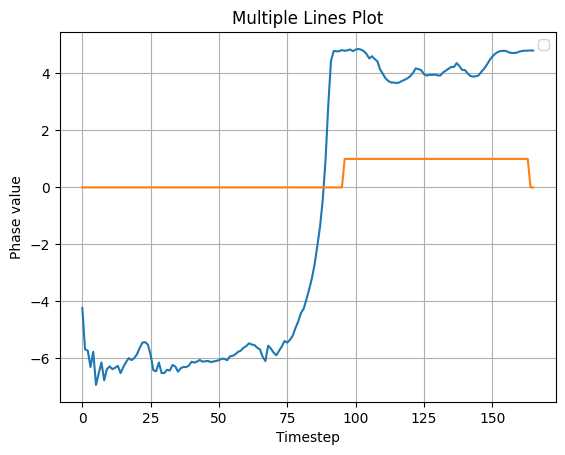

In [58]:
plot_multiple_lines(data, "Timestep", "Phase value")

89


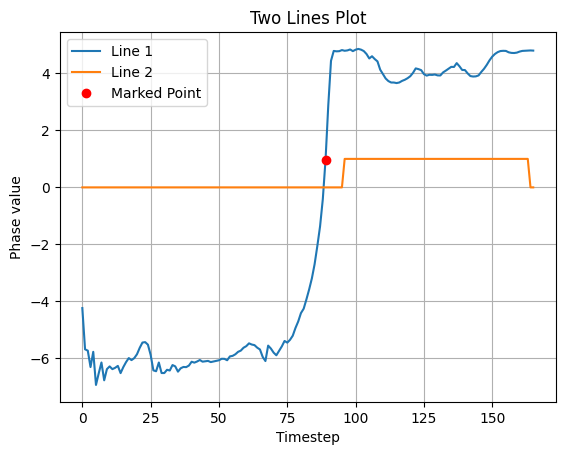

In [59]:
change_t = len(L)
for p in L:
    if p[1] > 0:
        print(p[0])
        change_t = p[0]
        plot_two_lines(L, L2, "Timestep", "Phase value", p)
        break

96


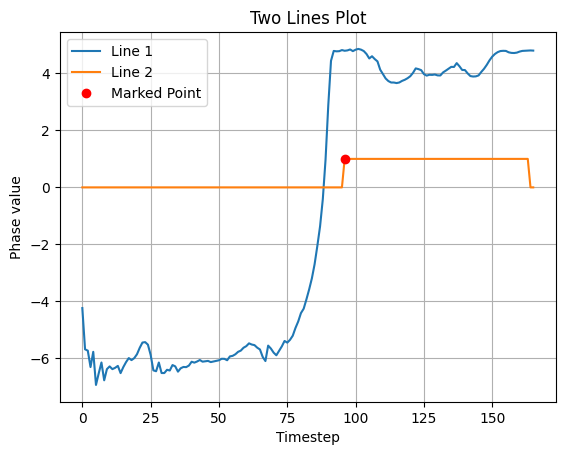

In [60]:
a_change_t = len(L)
for p in L2:
    if p[1] > 0:
        print(p[0])
        a_change_t = p[0]
        plot_two_lines(L, L2, "Timestep", "Phase value", p)
        break

In [61]:
def plot_heatmap(data, x_label, y_label):
    """Plots a heatmap of the given data.

    Args:
        data: A 2D list or numpy array representing the data for the heatmap.
        x_label: The label for the x-axis.
        y_label: The label for the y-axis.
    """
    plt.imshow(data, cmap='viridis', interpolation='nearest')  # You can change the colormap
    plt.colorbar()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Heatmap')

def plot_multiple_heatmaps(heatmap_data, x_labels, y_labels, titles=None):
    """Plots multiple heatmaps in a grid layout.

    Args:
        heatmap_data: A list of 2D numpy arrays representing the heatmap data.
        x_labels: A list of x-axis labels for each heatmap.
        y_labels: A list of y-axis labels for each heatmap.
        titles: A list of titles for each heatmap.
    """
    num_heatmaps = len(heatmap_data)
    cols = min(4, num_heatmaps)  # At most 4 heatmaps per row
    rows = (num_heatmaps + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.3) # Adjust spacing as needed


    for i, ax in enumerate(axes.flat):
        if i < num_heatmaps:
            im = ax.imshow(heatmap_data[i], cmap='viridis', interpolation='nearest')
            ax.set_xlabel(x_labels)
            ax.set_ylabel(y_labels)
            ax.set_title(titles[i])
            fig.colorbar(im, ax=ax) # Add colorbar
        else:
            ax.axis('off') # Hide unused subplots

    plt.show()

In [62]:
ran = range(80, 105)

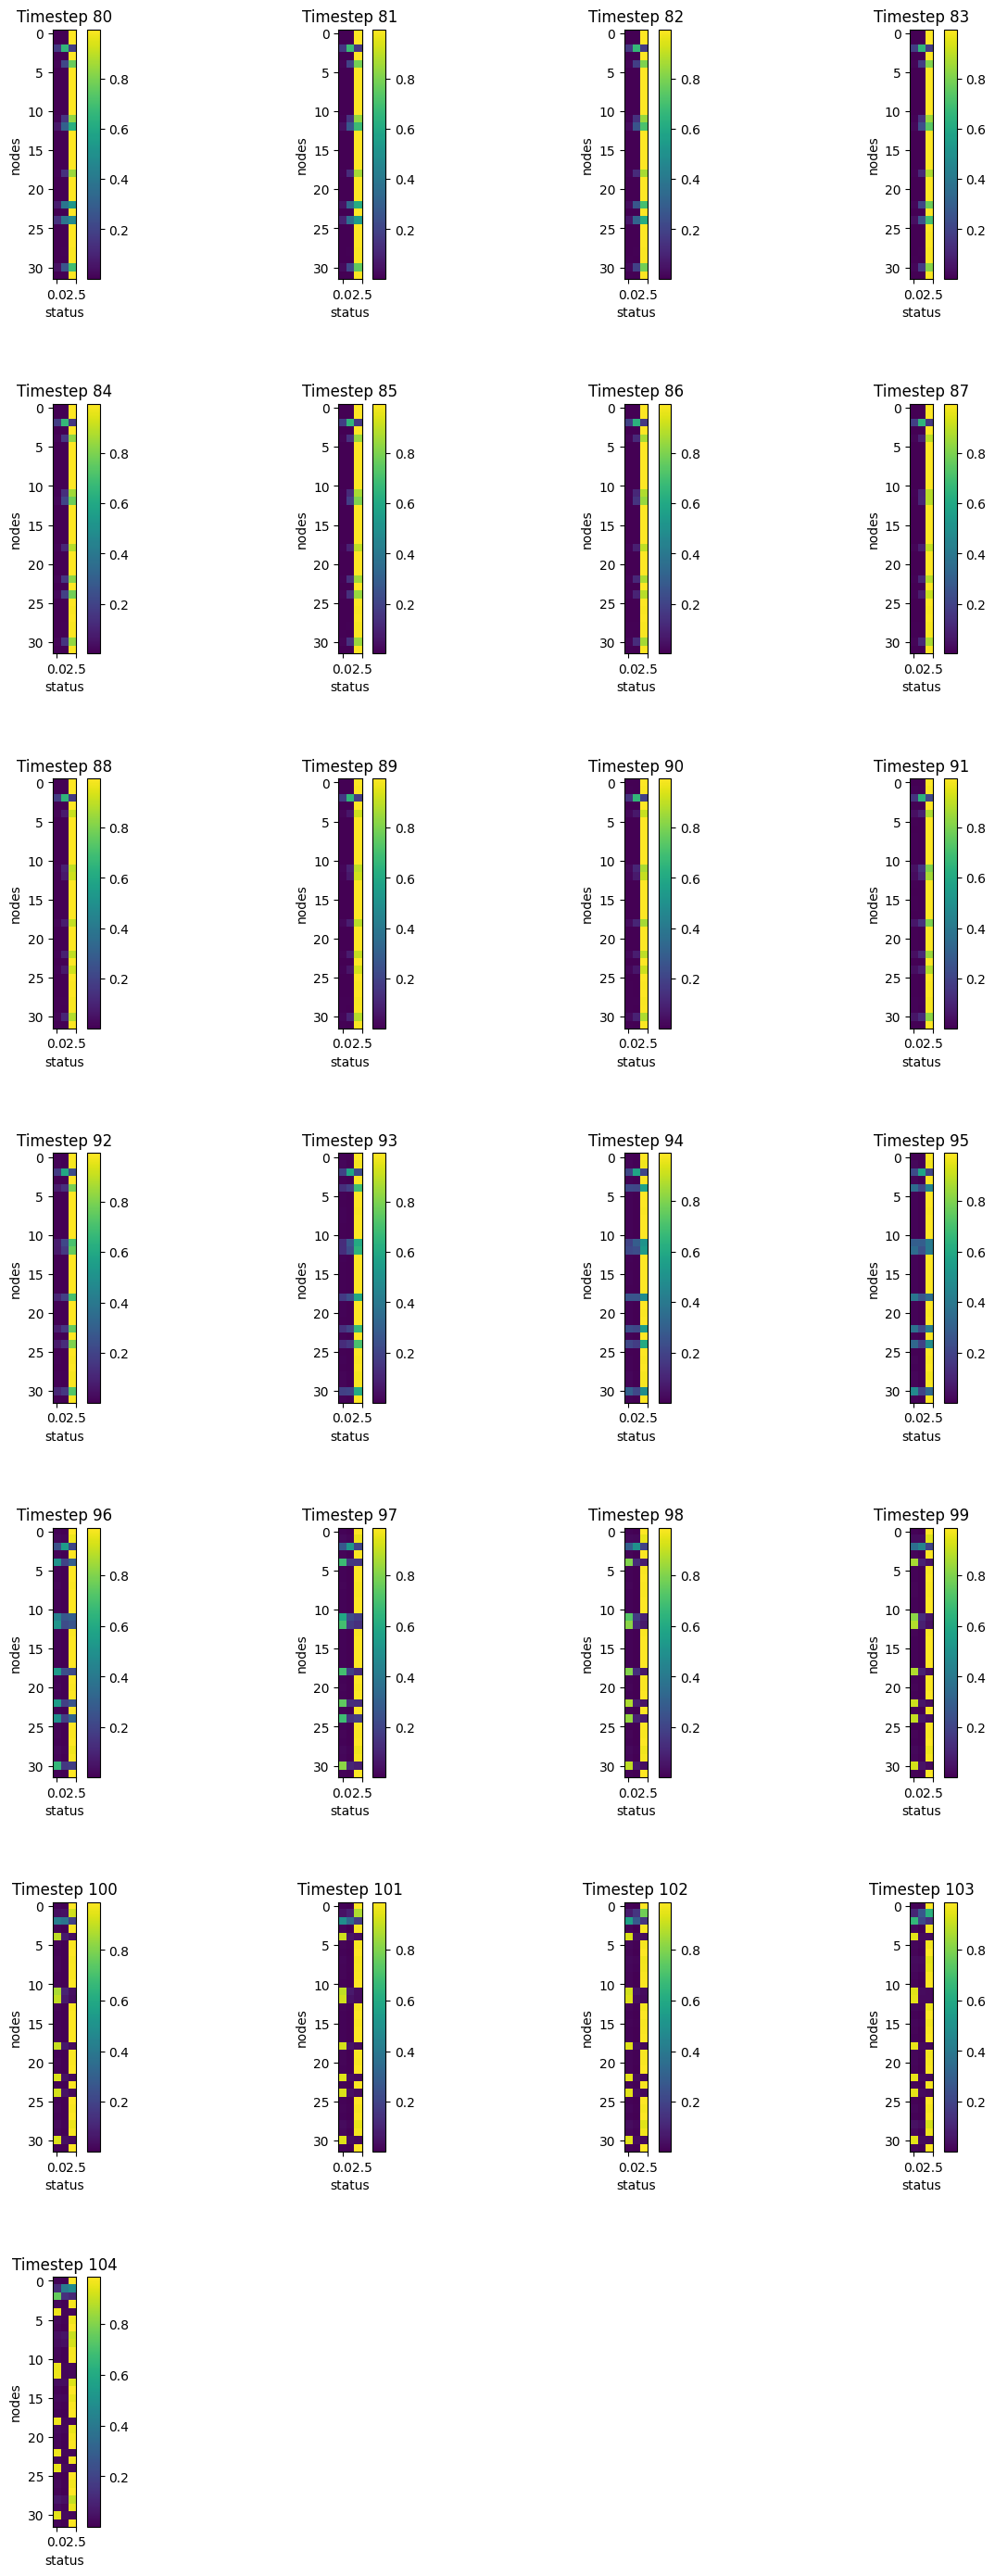

In [63]:
heatmaps = []
for i in ran:
    heatmaps.append(np.exp(h[i]['color'][0])/np.expand_dims(np.sum(np.exp(h[i]['color'][0]), axis=1), axis=1))

plot_multiple_heatmaps(heatmaps, "status", "nodes", ["Timestep " + str(i) for i in ran])

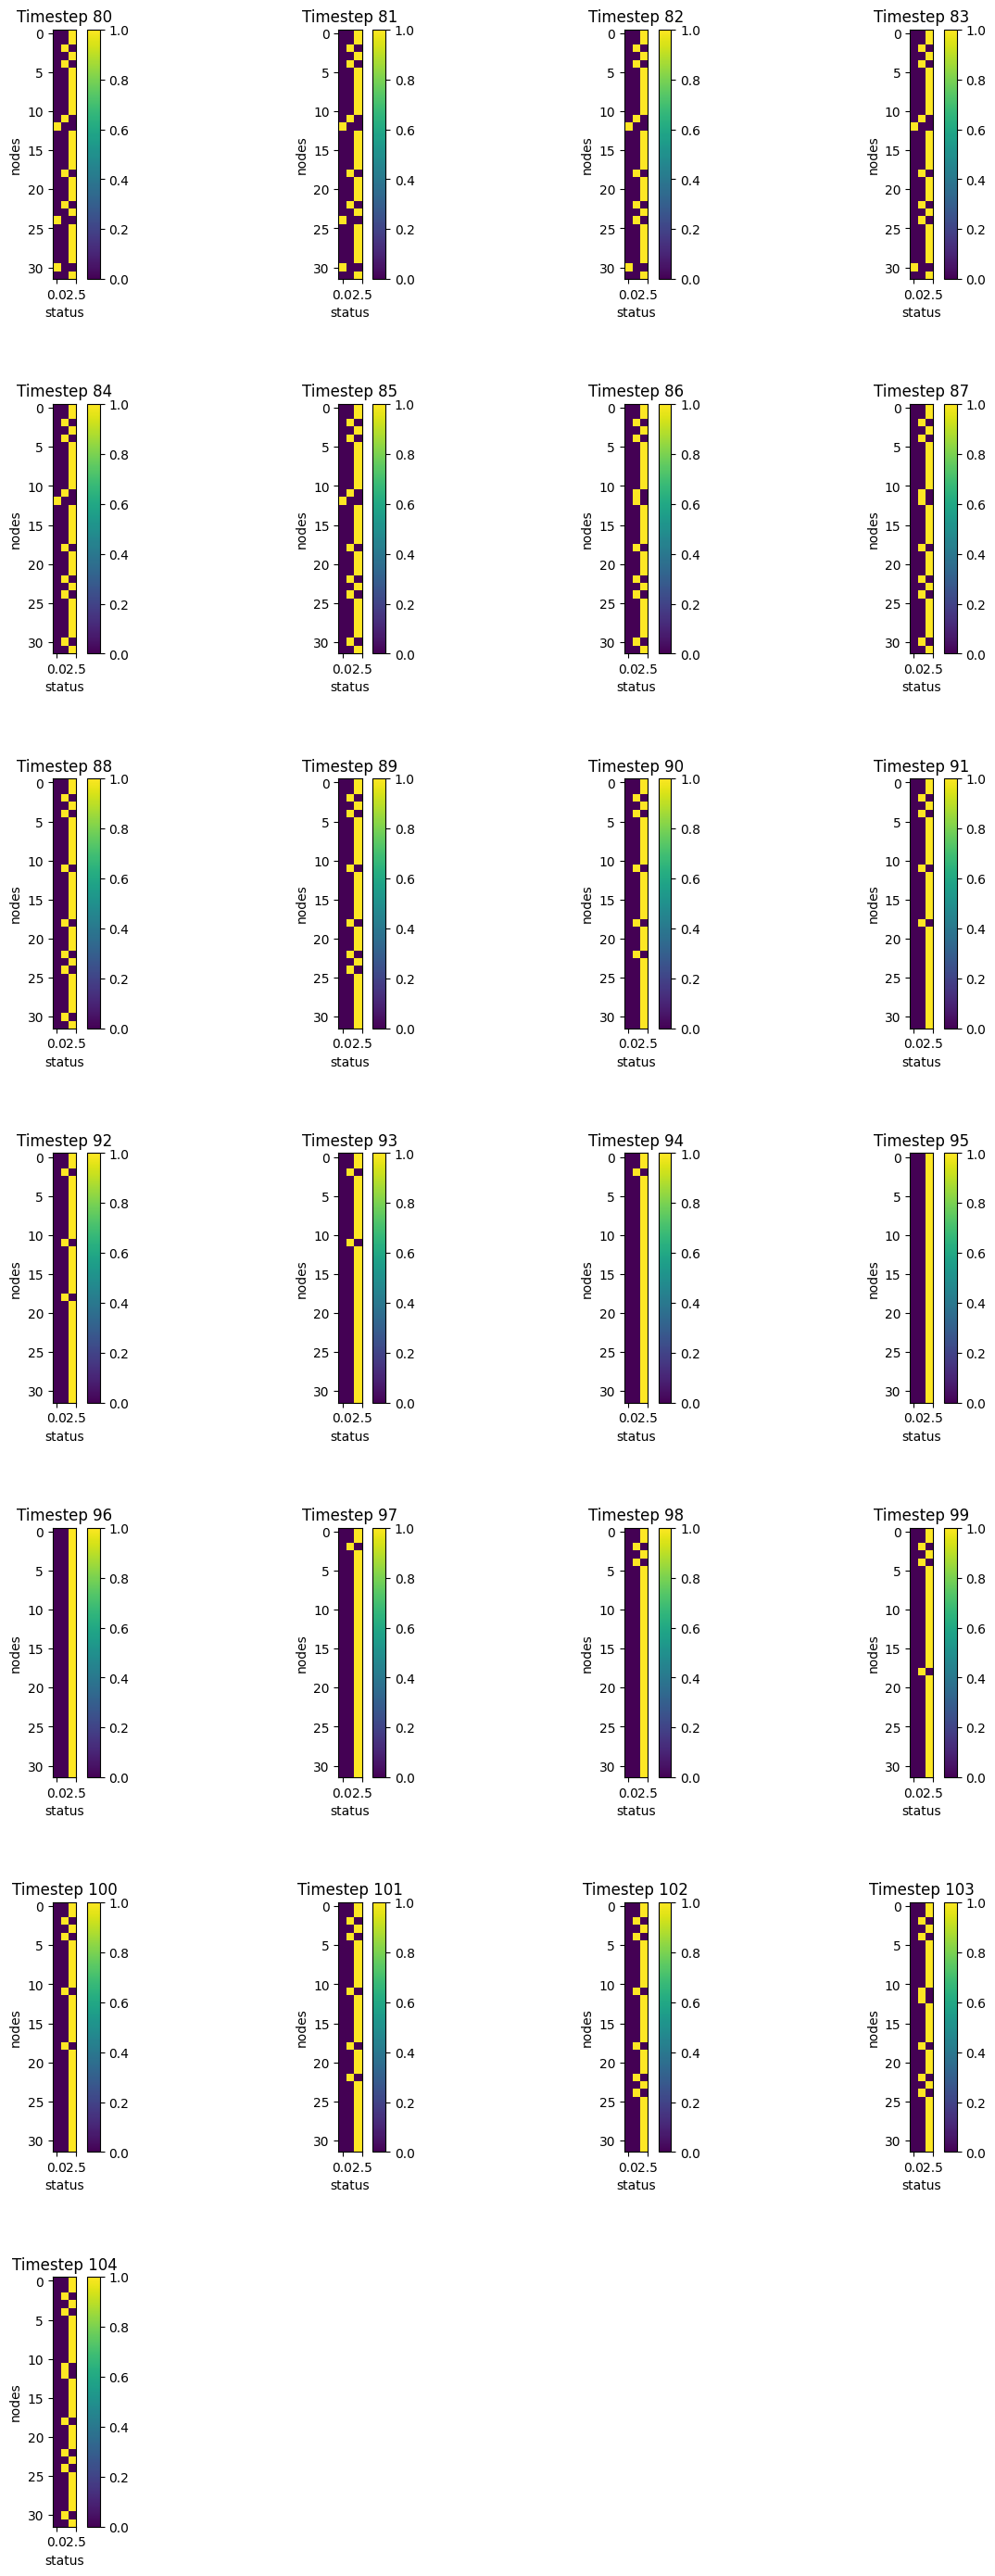

In [64]:
heatmaps = []
for i in ran:
    heatmaps.append(test_batch.features.hints[2].data[i][0])

plot_multiple_heatmaps(heatmaps, "status", "nodes", ["Timestep " + str(i) for i in ran])

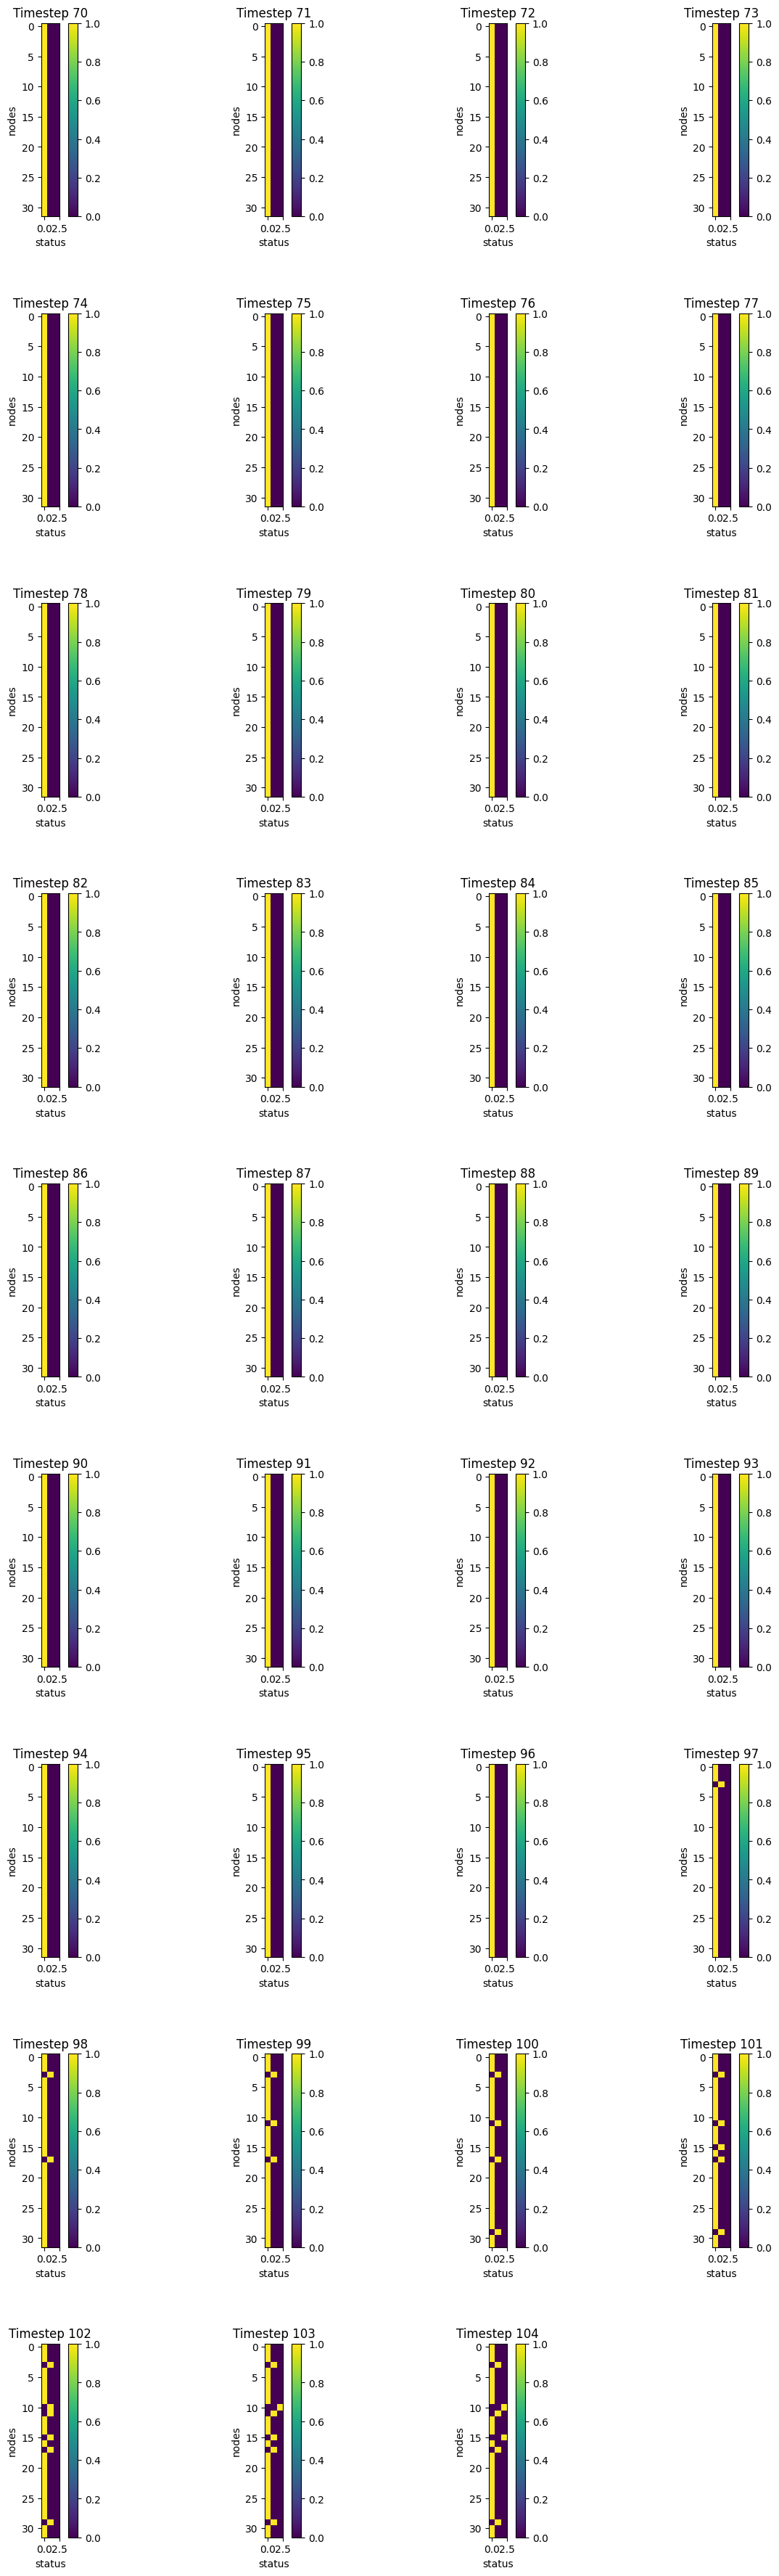

In [44]:
heatmaps = []
for i in ran:
    heatmaps.append(test_batch.features.hints[3].data[i][0])

plot_multiple_heatmaps(heatmaps, "status", "nodes", ["Timestep " + str(i) for i in ran])

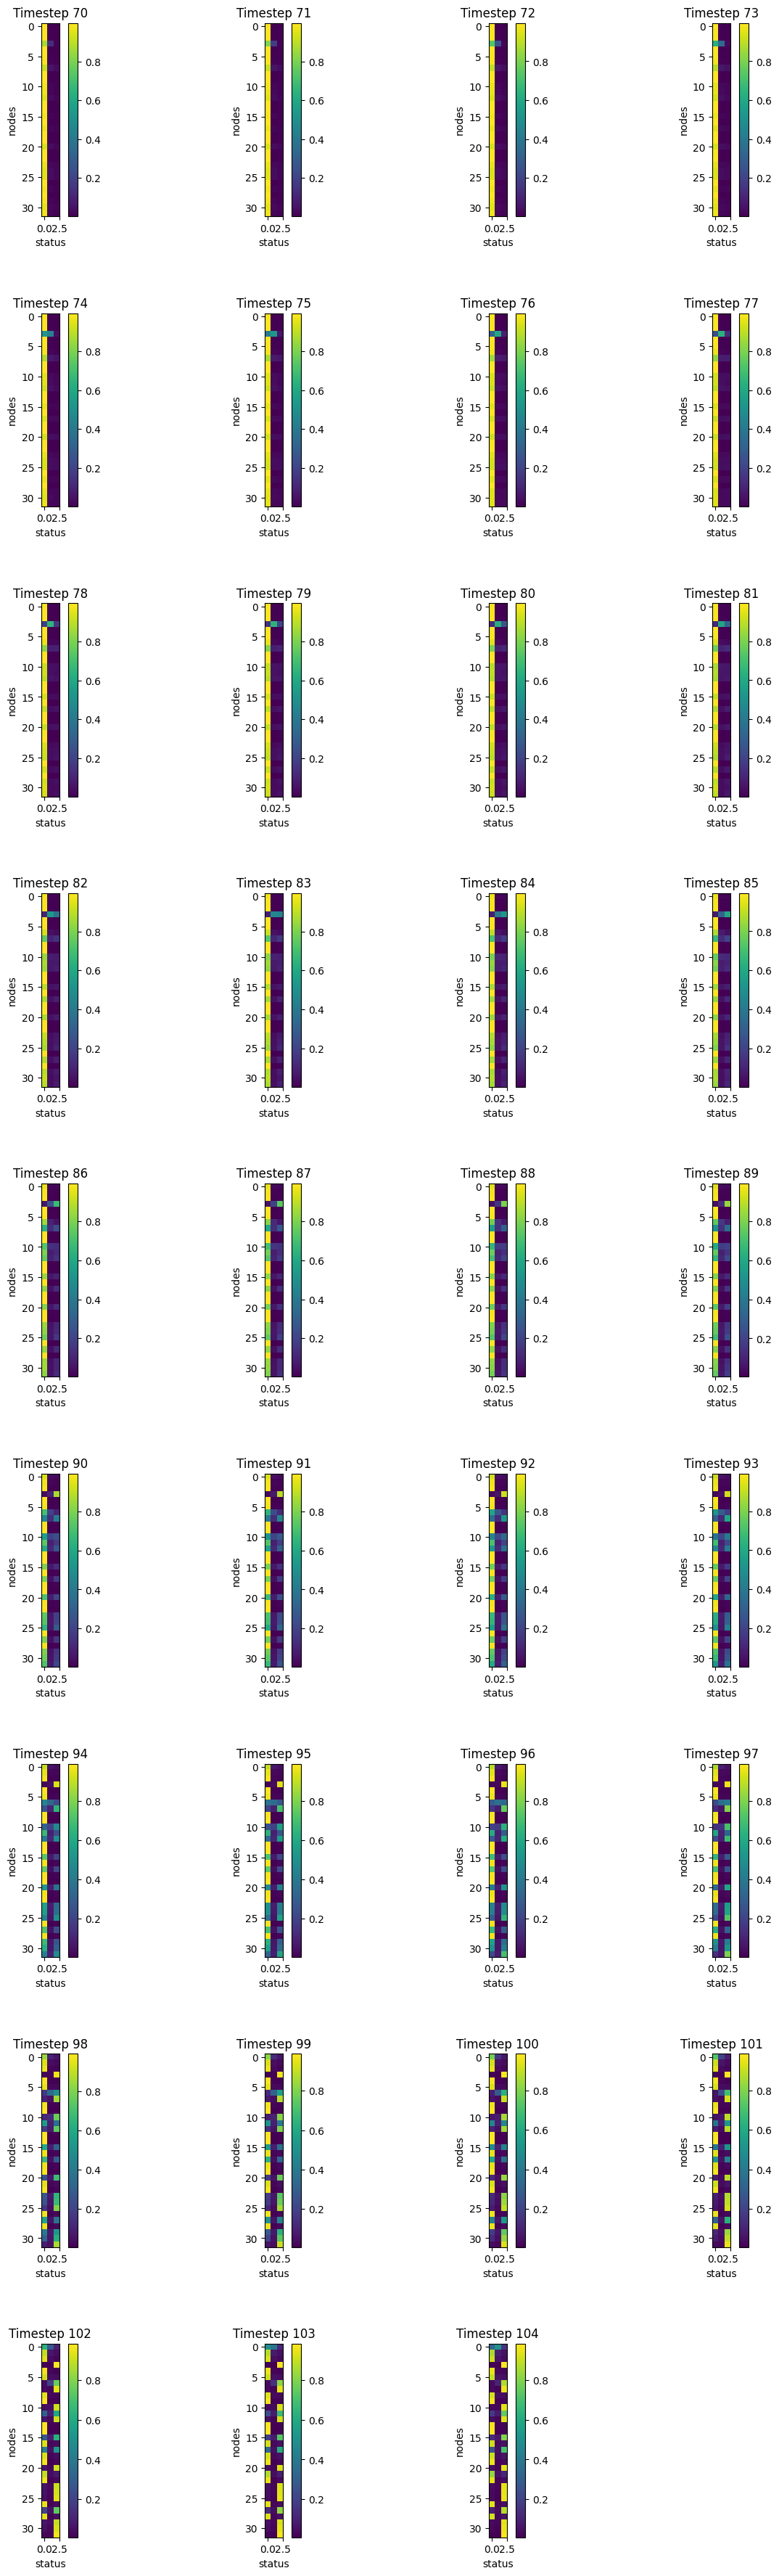

In [43]:
heatmaps = []
for i in ran:
    heatmaps.append(np.exp(h[i]['color2'][0])/np.expand_dims(np.sum(np.exp(h[i]['color2'][0]), axis=1), axis=1))

plot_multiple_heatmaps(heatmaps, "status", "nodes", ["Timestep " + str(i) for i in ran])